In [3]:
# Libraries required
import numpy as np
import random as rd
from matplotlib import pyplot as plt
from mnist import MNIST as mn
import time
from PIL import Image

%matplotlib inline

In [4]:
def centerData2(inputMatrix):
    
    """Center mean of each feature to 0"""
    # (x - mu)/sigma. Data is now centered at 0
    
    # Calculate mean and variance for each input feature
    variableMeans = np.mean(inputMatrix, axis = 0)
    
    # Centering with mean and return
    centerData = inputMatrix - variableMeans
    return centerData,variableMeans

In [150]:
# Lookup table of activation functions and derivatives
actLookup = {"sigmoid":lambda x: 1/(1 + np.exp(-1 * x)),
             "tanh":lambda x: np.tanh(x),
            "relu": lambda x: np.maximum(0,x)}

derivativeLookup = {"sigmoid": lambda x: x * (1.-x),
               "tanh": lambda x: 1. - (np.tanh(x) ** 2),
              "relu": lambda x: np.ceil(x.clip(0,1))}

# Weight Initialization strategy
# Random multiplies the initializations by a small number
# Xavier 1/sqrt(numInputs)
# For relu's, initalization is as recommended by He et. al(2015)
weightLookup = {"random":lambda x:0.01,
               "xavier":lambda x:1/sqrt(x),
               "he.et.al":lambda x:2/np.sqrt(x)}

# Regularization error component,
# 0 if none, sum(x^2) if L2 and sum(|x|) if L1
regLookup = {"none":lambda x: 0,
            "l2": lambda x: 0.5 * (x ** 2).sum(),
            "l1" : lambda x:sum(abs(x)),
            "l1+l2":lambda x: 0.5 * (x ** 2).sum() + sum(abs(x))}

# Derivatives of regularization terms
regDerivLookup = {"none": lambda x:0,
                "l2": lambda x: x,
                "l1": lambda x: 1,
                 "l1+l2":lambda x: x + 1}

# Momentum rate update
momentumLookup = {"none":0,
                  "momentum":lambda x:1,
                  "nag": lambda x: (1+x)}

In [151]:
class linearLayer(object):
    # A neural net layer with n neurons as defined by the user and an activation function for the layer
    # Init: Creates a new linear layer with weight init method, 
    # layer size and number of inputs as inputs
    # Forward propagation method: Dot product of input and weights
    # Backward propagation: Dot product of delta from next layer with weights
    # Weight update: Based on the per input dot product of the inputs and weights, 
    # weight gradient is calculated and Adam is used as learning method
    
    def __init__(self,numInputs, layerSize, weightInit = "random"):
    
        # Size of the layer and the number of inputs
        self.layerSize = layerSize

        # Incorporating the bias neuron
        self.numInputs = numInputs + 1
        self.inputMatrix = None
        
        # Numpy matrix of weights randomly initialized
        # Seed is set to ensure repeatability of weight initializations and hence convergence and outputs
        np.random.seed(seed=10000)
        self.weights = np.array(np.random.randn(self.layerSize,self.numInputs))/100 * \
        weightLookup[weightInit](self.numInputs)
        
        # Init backward propagation  and learning values (only Adam) for this layer
        self.delta = None
        self.m = np.zeros(self.weights.shape)
        self.velocity = np.zeros(self.weights.shape)
               
        
    # Defining the forward function to the layer
    def forward(self, inputMatrix):
        """Forward() forward propagates the inputs to a layer"""
        
        # Convert to numpy array if not passed as a numpy array
        if(not(isinstance(inputMatrix,np.ndarray))):
            inputMatrix = np.array(inputMatrix)
        
        # Get input matrix shape (m x n)
        rows, columns = inputMatrix.shape
        
        # Dot product of input matrix (with extra 1s for the bias neuron) with the weight matrix
        inputPadded = np.append(np.ones(rows).reshape(rows,1), inputMatrix, axis = 1)
        self.inputMatrix = inputPadded
        
        # Forward propagation is dot product of weights and input values
        self.output = np.dot(inputPadded, self.weights.T)
        return self.output
        
    # Defining the backward propagation function
    def backward(self, delta):
        """Backward takes the delta from next layer and passes it on the previous layer"""        
        
        # Local copy of delta
        self.delta = delta
        
        # Delta to pass on to preceding layer has to be 
        # matrix multiplication of these values by the weight matrix
        weightMatrix = self.weights[:,1:]
        
        # Delta passed back is the dot product of weights and deltas by 
        deltaBack = self.delta.dot(weightMatrix)
        return deltaBack
    
    # Adam only update since it is the latest learning technique
    def updateWeights(self, learnRate,
                      regularize = "none", lambdaReg = 0.01,
                      beta1 = 0.9, beta2 = 0.999, eps = 1e-8, t = 1):
        """updateWeights() uses the inputs and the delta stored in each layer after forward
        and backward propagation to derive the weight update rule"""
        
        # Depending on the Lookup 
        regDeriv = regDerivLookup[regularize]
        
        # The udpate rule for each element in the matrix is given by
        # wi = wi + sum_over_instances(delta for neuron * input i to neuron * learning rated)
        # Compute the weight updates for every data point and then add those updates
        rows,columns = self.inputMatrix.shape
        stepGradient = -1. * np.dot(self.inputMatrix.T,self.delta).T * (1/np.float(rows))
        
        # Regularization if applicable
        stepGradient = np.add(stepGradient, lambdaReg * regDeriv(self.weights))
        
        # First and second moments for Adam
        self.m = beta1 * self.m + (1. - beta1) * stepGradient
        self.velocity = beta2 * self.velocity + (1. - beta2) * (stepGradient ** 2)

        # Bias correction for Adam. THIS DOES NOT GET CARRIED OVER TO THE NEXT ITERATION
        biasM = self.m/(1. - beta1 ** t)
        biasVelocity = self.velocity/(1. - beta2 ** t)
    
        # Final Weight updates using Adam
        self.weights = np.add(self.weights, -learnRate * biasM / (np.sqrt(biasVelocity) + eps))

In [152]:
class activationLayer(object):
    # A neural net activation layer
    # It has the same methods as a linear layer but no weight updates are done on this layer
    # Forward only propagates inputs with activations performed on them
    # Backward propagates incoming delta by differentiating
    # d(activation) * delta by element
    
    def __init__(self, actFun = "sigmoid"):

        # Activation function
        self.actFun = actLookup[actFun]
        self.actDeriv = derivativeLookup[actFun]
        
    # Forward propagation is just activation of inputs
    def forward(self, inputMatrix):
        """Forward propagation is just passing through activation function"""
        
        # Propagation of inputs through activation
        # Saving inputs is not required since this layer 
        # does not have any input related weight updates
        self.output = self.actFun(inputMatrix)
        return self.output
    
    # Backward propagation is differential of inputs and delta from next layer
    def backward(self, delta):
        """Backward propagation multiplies delta from next layer with derivative"""
        
        # Delta for this layer is multiplication of outputs with delta
        return np.multiply(self.actDeriv(self.output), delta)
    
    def updateWeights(self, learnRate,
                      regularize = "none", lambdaReg = 0.01,
                      beta1 = 0.9, beta2 = 0.999, eps = 1e-8, t = 1):
        """Do nothing"""
        
        # Does nothing
        return

In [153]:
class dropoutLayer(object):
    # Dropout layer for neural nets
    # It creates a binary mask to drop certain outputs from the previous layer
    # Forward propagation is multiplication of each element of layer input
    # with the binary mask created
    # Backward propagation is delta multiplied by the binary mask and passed back
    
    def __init__(self, layerSize, p = 0.5):
        
        # p for binary and layer size are saved
        self.p = p
        self.layerSize = layerSize
        
    # Forward propagation is applying binary mask to the inputs
    def forward(self, inputMatrix):
        
        # Create binary mask at every epoch
        self.binaryMask = np.random.choice([0,1], size = self.layerSize,p = [self.p, 1.- self.p])
        
        # Return self.output as multiplication of binary mask
        self.output = np.multiply(inputMatrix, self.binaryMask)
        return self.output
    
    # Backward propagation for same iteration is reused
    def backward(self, delta):
    
        # Using the created binary mask
        deltaback = np.multiply(delta, self.binaryMask)
        return deltaback
    
    def updateWeights(self, learnRate,
                      regularize = "none", lambdaReg = 0.01,
                      beta1 = 0.9, beta2 = 0.999, eps = 1e-8, t = 1):
        """Do nothing"""
        
        # Does nothing
        return

In [154]:
class neuralNet(object):
    
    # Defining a neural net. To start, the object requires 
    
    def __init__(self, layers, actFun = "sigmoid", weightInit = "random"):
        
        self.layers = []
        
        for layerDesc in layers:
            
            # Check for layer type and create layer
            if(layerDesc["type"] == "linear"):
                # Layer creates linear combination
                self.layers.append(linearLayer(layerSize=layerDesc["layerSize"],
                                                            numInputs=layerDesc["numInputs"],
                                                            weightInit=weightInit))
                
            elif(layerDesc["type"] == "activation"):
                # Create activation layer
                self.layers.append(activationLayer(actFun=actFun))
    
            elif(layerDesc["type"] == "dropout"):
                # Create Dropout layer
                self.layers.append(dropoutLayer(layerSize=layerDesc["layerSize"],
                                                              p=layerDesc["p"]))
            else:
                "Print unknown layer type"
                
        
        # CV Error and Regularization loss initialization
        self.cvError = None
        self.regLoss= None
        
    # Compute MSE on the input        
    def computeError(self, inputs, outputs):
        
        predictions = self.predict(inputs)
        numRows = inputs.shape[0]
        # Calculate deltas and sum squares
        delta = np.subtract(predictions,outputs)
        totalError = np.sum(delta**2)/numRows
        return totalError
    
    # Calculate loss due to regularization
    def computeRegularizationLoss(self, regularize, lambdaReg):
        # Calculate layerWise sums and get total
        regLossFunction  = regLookup[regularize]
        linLayers = [layer for layer in self.layers if isinstance(layer,linearLayer)]
        layerRegs = np.array([lambdaReg * regLossFunction(layer.weights) for layer in linLayers])
        return(layerRegs.sum())
                
    # Defining forward propagation operation
    # Forward method of each layer is invoked
    def predict(self, inputMatrix): 
         
        """Prediction given current layer weights and input matrix"""
        
        for layer in self.layers:
            layerOut = layer.forward(inputMatrix)
            inputMatrix = layerOut
        
        self.output = layerOut
        return self.output
    
    # Defining the backprop operation
    def backProp(self, numEpochs, batchSize, learnRate,
                 trainInput, trainOutput, testInput,testOutput,
                 showStep = 1000, stepError = 100,
                 regularize = "none",lambdaReg = 0.01,
                 beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        """Training algorithm for the neural net"""
        
        
        if(not(isinstance(trainOutput,np.ndarray))):
            trainOutput = np.array(trainOutput)
        if(not(isinstance(trainInput,np.ndarray))):
            trainInput = np.array(trainInput)
        
        rows, columns = trainInput.shape
        
        
        # Initialize losses for the MSE and Regularization losses
        self.cvError = np.zeros(numEpochs/stepError * 2).reshape(numEpochs/stepError,2)        
        self.regLoss = np.zeros(numEpochs/stepError * 2).reshape(numEpochs/stepError,2)
                
        for i in range(numEpochs):
            
            # Run for a prespecified number of iterations
            if((i + 1) % showStep == 0):
                print i + 1
                
            if((i + 1) % stepError == 0):
                self.cvError[((i + 1) / stepError)-1] = [self.computeError(trainInput,trainOutput),
                                   self.computeError(testInput,testOutput)]
                
                self.regLoss[((i + 1) / stepError)-1] = [self.computeRegularizationLoss(regularize = regularize,
                                                                                        lambdaReg = lambdaReg)]
                
           # Pick a random sample from the trainInput and trainOutput
            # Updated weights based on the same. Sample size is to be of size batchSize
            
            randomIndices = np.random.choice(range(rows),size=batchSize)
            
            # Sample from trainInput and trainOutput
            batchTrain = trainInput[randomIndices,:].reshape(batchSize,columns)
            batchTest = trainOutput[randomIndices,:]
        
            # A forward pass through the network
            output = self.predict(batchTrain)
            
            # Iterate backwards through the layers to pass the deltas
            delta = np.subtract(batchTest,output)
            
            for layer in self.layers[::-1]:
                
                # Delta to be passed to the previous layer is computed
                delta = layer.backward(delta=delta)
                # Update weights as determined by the delta gradient
                layer.updateWeights(learnRate=learnRate, 
                                    regularize = regularize, lambdaReg = lambdaReg,
                                    beta1 = beta1, beta2 = beta2, eps = eps, t = i + 1)

In [10]:
mdata = mn(path='../datasets/MNIST/')

In [11]:
images,labels = mdata.load_training()
images = np.array(images)/255.
labels = np.array(labels).reshape(60000,1).astype(dtype = 'uint8')
labels = np.unpackbits(labels,axis=1)
labels = labels[:,4:8]

In [12]:
sampleIndices = np.random.choice(range(len(images)),size=10000)

In [13]:
imageTrain = images[sampleIndices]

In [14]:
labelTrain = labels[sampleIndices]

In [15]:
testImages,testLabels = mdata.load_testing()
testImages = np.array(testImages)/255.
testLabelsDigit = np.array(testLabels).reshape(10000,1).astype(dtype = 'uint8')
testLabels = np.unpackbits(testLabelsDigit,axis=1)
testLabels = testLabels[:,4:8]

In [16]:
sampleTestIndices = np.random.choice(range(len(testImages)), 2000)

In [17]:
imageTest = testImages[sampleTestIndices]

In [18]:
labelTestDigit = testLabelsDigit[sampleTestIndices]
labelTest = testLabels[sampleTestIndices]

In [171]:
nnet = neuralNet(layers = [{"type":"linear", "numInputs":784, "layerSize":400},
                           {"type":"activation"},
                           {"type":"linear", "numInputs":400, "layerSize":300},
                           {"type":"activation"},
                           {"type":"linear","numInputs":300,"layerSize":4},
                           {"type":"activation"}],
          actFun = "relu",
          weightInit = "he.et.al")

In [172]:
nnet.backProp(numEpochs = 20000, showStep=4000, stepError = 40,
              batchSize = 10, learnRate = 0.002, 
              trainInput = imageTrain, trainOutput = labelTrain, testInput = imageTest, testOutput = labelTest,
              regularize = "l2",lambdaReg = 1e-5,
              beta1 = 0.9, beta2 = 0.999, eps = 1e-8)

4000
8000
12000
16000
20000


In [173]:
# Compute accuracy of digit recognition
preds = nnet.predict(imageTest)
preds = np.array([np.round(arr) for arr in preds])
preds = np.append(np.zeros(8000).reshape(2000,4),preds,axis=1)
predDigits = np.packbits(preds.astype("bool"))
acc = [predDigits[i] == labelTestDigit[i] for i in range(2000)]
print sum(acc)/2000.

[ 0.9475]


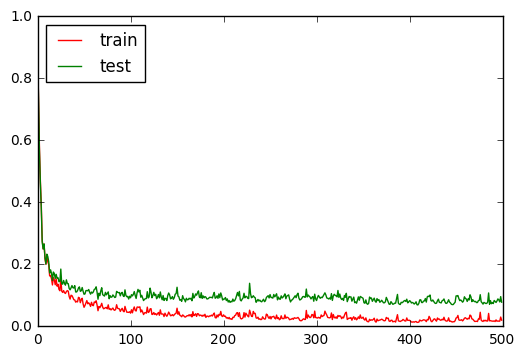

In [174]:
plt.plot(nnet.cvError[:,0],'r',label = 'train')
plt.plot(nnet.cvError[:,1],'g',label = 'test')
plt.legend(loc = 'upper left')
plt.show()

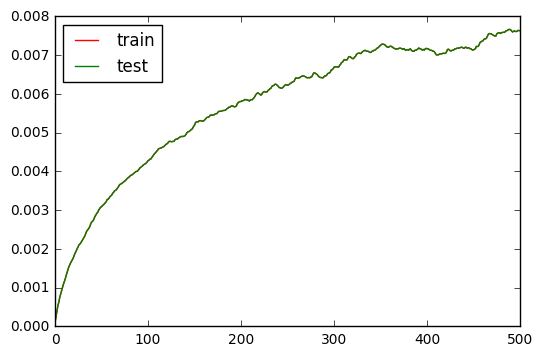

In [175]:
plt.plot(nnet.regLoss[:,0],'r',label = 'train')
plt.plot(nnet.regLoss[:,1],'g',label = 'test')
plt.legend(loc = 'upper left')
plt.show()